点郡データから標高ラスターを生成。パラメータ調整可能。（必要手続き：Driveの接続）

広域の初動の場合、初めて設定したmindepthを実行すると３０分ほどかかります。

ステップ２の再実行後はflag_renewをTrueにしてください。

全て実行した後、maxdepthを変更して外れ値処理以下を１度再実行できるぐらいのリソース有余です。２度目の再実行あたりでRAM不足でクラッシュしますので、RAMが少なそうならば再起動で実行してください。

In [ ]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# @title パラメータの設定
casename = "kurume-r2-rev2"

mindepth = 0.05 # assume minimal depth of water to be detected
maxdem = 300 # maximum dem assumed for water surface. set something unrealy high.

flag_renew = False # Set True if flood_pts.pkl has been updated.

In [ ]:
# @title 詳細設定用パラメータ（基本的には操作不要）

enable_savefig = False # 図をGoogleドライブに保存する？

zoomlevel = 15 # DEM zoom level to fetch
wall_height = 1000

analysis_tilesize = 4

errordem = -1000

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
path_dem = path_home + "/DEM/"
path_case = path_home + casename + "/"
file_flbbox = path_case + "floodprb_bbox.npy"
file_pts = path_case + "flood_points.pkl"
file_dem_fmt = path_case + "dem_{}_{}-{}_{}-{}.npz"
file_savepts = path_case + "save_pts.npy"

file_pts_mindepth = path_case + "flood_points_min{0:04d}.pkl"

file_flooddem = path_case + "flood_dem_{0:04d}.npz"
file_flooddepth = path_case + "flood_depth_{0:04d}.npz"

# 標高データの基本パラメータ
demtile_len = 256

In [ ]:
# @title 主要ライブラリインポート
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import requests
import os
#import cv2
from scipy import ndimage as ndi
from progressbar import progressbar
from sklearn.ensemble import IsolationForest
from shapely import box
import sys
sys.path.append(path_home)
import plateau_floodsar_lib as pfsl

In [ ]:
# @title 領域の読み込み
boundbox = np.load(file_flbbox)
print(boundbox)

[130.40008279  33.22512157 130.6999996   33.36663976]


## 国土地理院の標高データの取得

In [ ]:
# @title DEMマップ取得
print(boundbox)
bbox = box(*boundbox)
print(bbox)
gdm = pfsl.GiajDemManager(path_home,dem_types = [{"type":"dem5a","z":15},{"type":"dem5b","z":15}])
gdm.load_dem_tiles(bbox)
tile = gdm.produce_tile_stiched()
lons = tile["lons"]
lats = tile["lats"]
demmap = tile["dem"]

[130.40008279  33.22512157 130.6999996   33.36663976]
POLYGON ((130.69999959514536 33.225121566010124, 130.69999959514536 33.366639756095395, 130.40008279106954 33.366639756095395, 130.40008279106954 33.225121566010124, 130.69999959514536 33.225121566010124))


100% (28 of 28) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


In [ ]:
print("dem range = ", np.nanmin(demmap), np.nanmax(demmap))

dem range =  -3.2 698.04


## 標高に基づいた浸水域の拡大

In [ ]:
scale = np.concatenate([np.arange(3,10,1),np.arange(10,maxdem+30,30)])
print(scale)

[  3   4   5   6   7   8   9  10  40  70 100 130 160 190 220 250 280 310]


In [ ]:
vbi = pfsl.ValueBoundInspector(gdm, scale=scale)#, method=lambda data,x:data>=x)
vbi.set_cntrs_all()


  0% (0 of 18) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Preparing all contours


100% (18 of 18) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


In [ ]:
#@title 点郡の読み込み＆DEM情報付与
pts_filepath = file_pts_mindepth.format(int(mindepth*100))
if flag_renew or os.path.isfile(pts_filepath):
  print(f"Loading the previous result from {pts_filepath}")
  with open(pts_filepath, "rb") as ifile:
    flood_pts = pickle.load(ifile)
else:
  with open(file_pts, "rb") as ifile:
    flood_pts = pickle.load(ifile)
  for pt in progressbar(flood_pts):
    try:
      pt["dem"] = gdm.calc_dem_interp(pt["lon"],pt["lat"])+mindepth
    except IndexError:
      pt["dem"] = np.nan
  flood_pts = [pt for pt in flood_pts if pt["dem"] <= maxdem]
  for pt in progressbar(flood_pts):
      pt["area"] = vbi.calc_area_bound(pt["lon"],pt["lat"],pt["dem"])
      pt["mindem"] = vbi.get_mindem_bound(pt["lon"],pt["lat"],pt["dem"])
      pt["maxdepth"] = pt["dem"] - pt["mindem"]
  with open(pts_filepath, "wb") as ofile:
    pickle.dump(flood_pts, ofile)
  print(f"The points are saved to {pts_filepath} for future runs.")
print(len(flood_pts))
print(flood_pts[0:3])
print(demmap.shape)
print(lats.shape)
print(lons.shape)

Loading the previous result from /content/drive/MyDrive/PLATEAU-FloodSAR/kurume-r2-rev2/flood_points_min0005.pkl
3584019
[{'lon': 130.400244024231, 'lat': 33.30722209485701, 'dem': 4.487365755602971, 'area': nan, 'mindem': 1.1, 'maxdepth': 3.387365755602971}, {'lon': 130.400237224806, 'lat': 33.30725499812434, 'dem': 4.5501742710636135, 'area': nan, 'mindem': 1.1, 'maxdepth': 3.4501742710636134}, {'lon': 130.40028526947094, 'lat': 33.30726580379134, 'dem': 4.578011809725311, 'area': nan, 'mindem': 1.1, 'maxdepth': 3.4780118097253108}]
(4096, 7168)
(4096,)
(7168,)


In [ ]:
del gdm

In [ ]:
vbi.release_cntrs_all()  # 事前計算領域の削除、メモリー領域の開放

In [ ]:
#xx = [pt["lon"] for pt in selected_pts]
#yy = [pt["lat"] for pt in selected_pts]
#ax =plt.subplot(1,1,1)
#img = ax.contourf(lons,lats,demmap)
#ax.scatter(xx,yy,c="y",s=1)
#plt.colorbar(img)
#ax.axis("equal")

### 外れ値処理

In [ ]:
def sort_floodpts_without_outliers(flood_pts):
  #fd = [[pt["lon"],pt["lat"],pt["area"]] for pt in flood_pts]
  fd = [[pt["dem"], pt["area"]] for pt in flood_pts]
  isolation_forest = IsolationForest()
  isolation_forest.fit(fd)
  # Predicting the anomalies (1 if anomaly, -1 if normal)
  predictions = isolation_forest.predict(fd)
  tmplst = []
  for pt, prd in zip(flood_pts, predictions):
    if prd == 1:
      tmplst.append(pt)
  return sorted(tmplst, key=lambda pt:pt["dem"], reverse=True)

(0.0, 10.0)

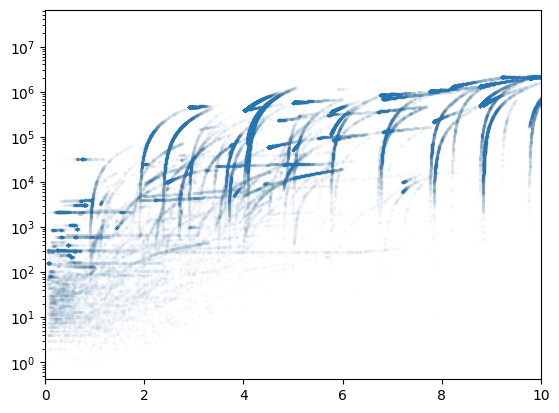

In [ ]:
xx = [ee["maxdepth"] for ee in flood_pts]
yy = [ee["area"] for ee in flood_pts]
ax =plt.subplot(1,1,1)
ax.scatter(xx,yy, s=3, alpha=0.01)
plt.yscale('log')
ax.set_xlim(0, 10)
#ax.set_ylim(0,2e4)

In [ ]:
 maxdepth = 4.27 #4 # m
 maxarea = 10000 # in the unit of pixels or 25 m^2

In [ ]:
selected_pts = [pt for pt in flood_pts if pt["maxdepth"] < maxdepth]# pt["area"]<=maxarea]
print(len(selected_pts))

930341


In [ ]:
sorted_pts = sorted(selected_pts, key=lambda x:x["dem"], reverse=True)

In [ ]:

floodmap_msk = np.zeros_like(vbi.data, dtype=float)
floodmap_dem = np.ones_like(vbi.data) * errordem
save_pts = []
cnt0 = 10000
cnt = cnt0
for pt in progressbar(sorted_pts):
  cx, cy = vbi.calc_floatIdxs(pt["lon"],pt["lat"])
  cx = int(cx)
  cy = int(cy)
  if pt["area"] > 0 and floodmap_msk[cy,cx] == 0: #and floodmap_dem[cy,cx] < pt["dem"]:
    #print(cx, cy, floodmap[cx,cy], ee["dem"])
    tmp_msk = vbi.generate_boundmap_exact(pt["lon"],pt["lat"], pt["dem"])
    tmp_dem = tmp_msk * pt["dem"] + (1-tmp_msk) * errordem
    #tmp_dem[np.where(tmp_msk == 0)] = errordem
    #tmp_depth = np.nanmax(tmp_dem - vbi.data)
    #if tmp_depth <= maxdepth:
    cnt = cnt  - 1
    tmp_id = tmp_msk * cnt
    #floodmap_msk[np.where(floodmap_msk)==0] = tmp_msk[np.where(floodmap_msk)==0] * cnt
    floodmap_msk = np.maximum(floodmap_msk, tmp_id)
    floodmap_dem = np.maximum(floodmap_dem, tmp_dem)
    save_pts.append(pt)
floodmap_dem = floodmap_dem[1:-1,1:-1]
floodmap_dem[np.where(floodmap_dem == errordem)] = np.nan
floodmap_msk = floodmap_msk[1:-1,1:-1]
floodmap_msk[np.where(floodmap_msk)==0] = np.nan
floodmap_msk = cnt0 - floodmap_msk
cnt = cnt0-cnt

100% (930341 of 930341) |################| Elapsed Time: 0:02:12 Time:  0:02:12


In [ ]:
print(cnt)
print(np.nanmin(floodmap_msk),np.nanmax(floodmap_msk))
print(floodmap_msk)
print(floodmap_dem)

273
1.0 10000.0
[[271. 271. 271. ... 271. 271. 271.]
 [271. 271. 271. ... 271. 271. 271.]
 [271. 271. 271. ... 271. 271. 271.]
 ...
 [271. 271. 271. ... 271. 271. 271.]
 [271. 271. 271. ... 271. 271. 271.]
 [271. 271. 271. ... 271. 271. 271.]]
[[2.51365433 2.51365433 2.51365433 ... 2.51365433 2.51365433 2.51365433]
 [2.51365433 2.51365433 2.51365433 ... 2.51365433 2.51365433 2.51365433]
 [2.51365433 2.51365433 2.51365433 ... 2.51365433 2.51365433 2.51365433]
 ...
 [2.51365433 2.51365433 2.51365433 ... 2.51365433 2.51365433 2.51365433]
 [2.51365433 2.51365433 2.51365433 ... 2.51365433 2.51365433 2.51365433]
 [2.51365433 2.51365433 2.51365433 ... 2.51365433 2.51365433 2.51365433]]


In [ ]:
demmap = vbi.data[1:-1,1:-1]
depthmap = floodmap_dem - demmap
depthmap[np.where(depthmap < 0)] = np.nan
floodmap_dem[np.where(np.isnan(depthmap))] = np.nan
floodmap_msk[np.where(np.isnan(depthmap))] = np.nan

In [ ]:
print(depthmap)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
print(floodmap_msk)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


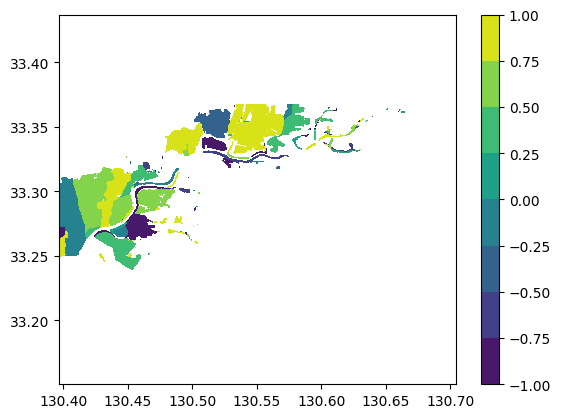

In [ ]:

ax =plt.subplot(1,1,1)
img = ax.contourf(lons,lats, np.sin(floodmap_msk*0.1))#,levels=np.arange(1,cnt+10,10))
ax.axis("equal")
plt.colorbar(img)

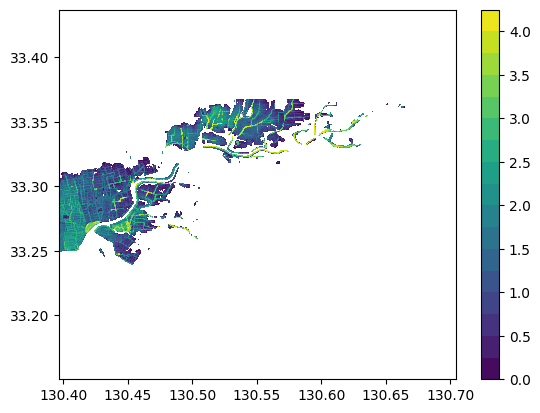

In [ ]:

ax =plt.subplot(1,1,1)
img = ax.contourf(lons,lats, depthmap,levels=np.arange(0,maxdepth+0.1,0.25))
ax.axis("equal")
plt.colorbar(img)
#ax.set_xlim(130.4,130.5)
#ax.set_ylim(33.22,33.32)

(33.22, 33.32)

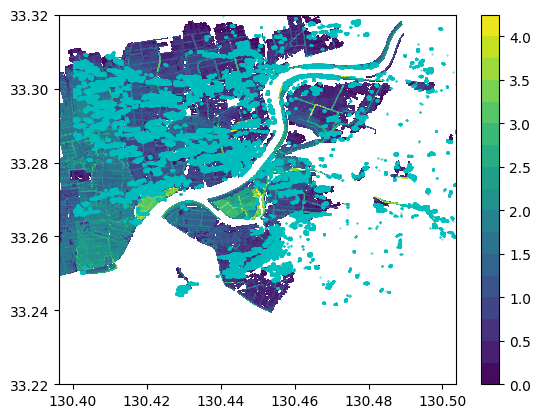

In [ ]:
xx = [pt["lon"] for pt in sorted_pts]
yy = [pt["lat"] for pt in sorted_pts]
ax =plt.subplot(1,1,1)
img = ax.contourf(lons,lats, depthmap,levels=np.arange(0,maxdepth+0.1,0.25))
plt.colorbar(img)
ax.scatter(xx,yy, c="c", s=0.1)
ax.axis("equal")
ax.set_xlim(130.4,130.5)
ax.set_ylim(33.22,33.32)

In [ ]:
del img

In [ ]:
print(floodmap_dem)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
print(len(save_pts))

273


In [ ]:
np.savez(file_flooddem.format(int(maxdepth*100)), lons=lons, lats=lats, floodmap_dem=floodmap_dem)
np.savez(file_flooddepth.format(int(maxdepth*100)), lons=lons, lats=lats, floodmap_depth=depthmap)